Imports

In [1]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from datetime import datetime
from tqdm import tqdm
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2    
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dropout, ConvLSTM2D, Softmax, Lambda
from tensorflow.keras.layers import Conv3D, BatchNormalization, Activation, Conv3DTranspose, UpSampling3D, Concatenate, LayerNormalization, ReLU, Add, Multiply
from tensorflow.keras import Model
from tensorflow.keras import layers, models
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2
from keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.backend import clear_session
from scipy.spatial.distance import directed_hausdorff
import sys
sys.path.append(os.path.abspath('../utils/'))
from data_utilities_v2 import *
import glob

2025-03-25 17:17:04.779308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-25 17:17:04.847365: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 17:17:05.131950: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dministrator/miniconda3/envs/tf/lib/
2025-03-25 17:17:05.133016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer

In [3]:
clear_session()

In [ ]:
import wandb
epochs = 100
optimizer = tf.keras.optimizers.Adam()
wandb.init( 
           project="IFFS-Net",
           config={
               "epochs": epochs,
               "learning_rate": optimizer.learning_rate.numpy(),
               
           })


I0000 00:00:1742468615.393232   39765 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: diego-gonca-simao (diego-gonca-simao-basel) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
# Check if TensorFlow is built with GPU support
print("Built with GPU support:", tf.test.is_built_with_cuda())

# List available physical devices (CPU/GPU)
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print(f"Number of GPUs available: {len(physical_devices)}")
    for i, gpu in enumerate(physical_devices):
        print(f"GPU {i}: {gpu}")
else:
    print("No GPU available.")

Built with GPU support: True
Number of GPUs available: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2025-03-25 16:57:14.036833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 16:57:14.124323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 16:57:14.124444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Process all folder
## File Format Requirements:
# 1. Input Data Structure:
#    - The data should be organized in a directory structure as follows:
#      raw_data/
#        |- <patient_number>/
#        |   |- <mzp_folder>/
#        |       |- VL_<mzp_folder>_<patient_number>.nrrd
#        |       |- Segmentation_VL_<mzp_folder>_<patient_number>.seg.nrrd
#    - Example:
#      raw_data/
#        |- 001/
#        |   |- MZP1/
#        |       |- VL_MZP1_001.nrrd
#        |       |- Segmentation_VL_MZP1_001.seg.nrrd
#        |   |- MZP2/
#        |       |- VL_MZP2_001.nrrd
#        |       |- Segmentation_VL_MZP2_001.seg.nrrd
#
# 2. File Naming Conventions:
#    - Volume file: `VL_<mzp_folder>_<patient_number>.nrrd`
#    - Mask file: `Segmentation_VL_<mzp_folder>_<patient_number>.seg.nrrd`
#
# 3. Output Data Structure:
#    - The results will be saved in the following directory structure under `compact_analyzed_data`:
#      compact_analyzed_data/
#        |- mask/
#        | |- <patient1_number>/
#        |   |- <mzp1_folder>/
#        |     |- frame_00000.tif/
#        |     |- frame_00001.tif/
#        |   |- <mzp2_folder>/
#        | |- <patient2_number>/ 
#        |   |- <mzp1_folder>/
#        |     |- frame_00000.tif/
#        |     |- frame_00001.tif/
#        |
#        |- volume/
#        | |- <patient1_number>/
#        |   |- <mzp1_folder>/
#        |     |- frame_00000.tif/
#        |     |- frame_00001.tif/
#        |   |- <mzp2_folder>/
#        | |- <patient2_number>/ 
#        |   |- <mzp1_folder>/
#        |     |- frame_00000.tif/
#        |     |- frame_00001.tif/
# Usage:
# - To process all patients in the `raw_data` directory, use the batch processing function.
# - To process a single patient, provide the exact file paths for the volume and mask files.

In [ ]:
# Paths for input and output data
raw_data_path = "C:/Users/diego/Bac Sport and Computer Science/BA-arbeit/RepoBA/BA-IFSS/data/raw_data"
analyzed_data_path = "C:/Users/diego/Bac Sport and Computer Science/BA-arbeit/RepoBA/BA-IFSS/data/compact_analyzed_data"

# Process all patient data
process_raw_data(raw_data_path, analyzed_data_path, threshold=10)

In [2]:
# Example usage for a single patient
patient_number = "005"
mzp_folder = "MZP1"
volume_file_path = "../data/raw_data/VL_005_MZP1.nrrd"
mask_file_path = "../data/raw_data/Segmentation.seg.nrrd"
analyzed_data_path = "../data/test"

process_single_patient(patient_number, mzp_folder, volume_file_path, mask_file_path, analyzed_data_path, threshold=10)

## Conversion NRRD to H5

In [5]:
#convert_nrrd_to_h5(args.nrrd_file)

## Conversion tif to npz

# Input format:
# subfolders before .tif

In [ ]:
volume_folder= "../data/analyzed_copy/volume/Patient5/MZP1"
mask_folder= "../data/analyzed_copy/mask/Patient5/MZP1"
original_height, original_width = 667, 703
export_tif_to_npz(volume_folder, mask_folder, original_height, original_width)

## Loss definitions

In [5]:
# taken from https://github.com/nabsabraham/focal-unet/blob/master/losses.py

epsilon = 1e-5
smooth = 1

def focal_loss(alpha=0.5, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1.0 - 1e-7)
        loss = -y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred)
        return K.mean(loss)
    return loss

def dsc(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    smooth = 1.
    axis = (1,2,3,4)
    #y_true_f = K.flatten(y_true)
    #y_pred_f = K.flatten(y_pred)
    y_true_f = tf.reduce_sum(y_true, axis=axis)
    y_pred_f = tf.reduce_sum(y_pred, axis=axis)

    intersection = tf.reduce_sum(y_true * y_pred)

    #score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    score = (2. * intersection + smooth) / (y_true_f + y_pred_f + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 

def tversky(y_true, y_pred):
    # Ensure both y_true and y_pred are of the same type (float32)
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    axis = (1,2,3,4)
    P_foreground = y_pred[:,:,:,:,:1]
    P_background = y_pred[:,:,:,:,1:]
    g_foreground = y_true[:,:,:,:,:1]
    g_background = y_true[:,:,:,:,1:]

    #y_true_pos = K.flatten(y_true)
    #y_pred_pos = K.flatten(y_pred)
    true_pos = P_foreground * g_foreground
    true_pos = tf.reduce_sum(true_pos, axis=axis)

    false_pos = P_foreground * g_background
    false_pos = tf.reduce_sum(false_pos, axis=axis)

    false_neg = P_background * g_foreground
    false_neg = 0.5*tf.reduce_sum(false_neg, axis=axis)

    #true_pos = K.sum(y_true_pos * y_pred_pos)
    #false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    #false_pos = K.sum((1 - y_true_pos) * y_pred_pos)

    alpha = 0.8
    smooth = 1e-6

    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 1.33
    return K.pow((1-pt_1), gamma)

def IoU(y_true, y_pred, dtype=tf.float32):
    y_pred = tf.cast(y_pred, dtype)
    y_true = tf.cast(y_true, y_pred.dtype)

    y_pred = tf.squeeze(y_pred)
    y_true = tf.squeeze(y_true)

    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])

    area_intersect = tf.reduce_sum(tf.multiply(y_true_pos, y_pred_pos))

    area_true = tf.reduce_sum(y_true_pos)
    area_pred = tf.reduce_sum(y_pred_pos)
    area_union = area_true + area_pred - area_intersect

    return tf.meth.divide_no_nan(area_intersect, area_union)

## Definition of IFSS utilities

In [6]:
def Conv3DBlock(
    inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 1, 1], activation_fn="relu"
):
    """
    Builds the 3d conv block
    Apply successivly a 3D convolution, BatchNormalization and relu
    """
    # Skip pointwise by setting num_outputs=Non
    net = Conv3D(
        filters=n_filters,
        kernel_size=kernel_size,
        strides=stride,
        padding="same",
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
    )(inputs)
    net = BatchNormalization()(net)
    #net = LayerNormalization()(net)
    net = Activation(activation_fn)(net)

    return net

def Conv3DBlockTranspose(
    inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 1, 1], activation_fn="relu"
):
    """
    Builds the 3d conv transpose block
    Apply successivly a 3D transpose convolution, BatchNormalization and relu
    """
    # Skip pointwise by setting num_outputs=Non
    net = Conv3DTranspose(
        filters=n_filters,
        kernel_size=kernel_size,
        strides=stride,
        padding="same",
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
    )(inputs)
    net = BatchNormalization()(net)
    #net = LayerNormalization()(net)
    net = Activation(activation_fn)(net)

    return net



def AtrousSpatialPyramidPoolingModule_3D(inputs, depth=256):
    """
    5D Tensor: batch, time, H, W, C
    """
    # feature_map_size = tf.shape(inputs)

    # Global average pooling
    image_features = tf.keras.layers.Lambda(
        lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True)
    )(inputs)
    
    image_features = Conv3D(
        depth,
        (1, 1, 1),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(image_features)

    image_features = UpSampling3D(size=(1, int(inputs.shape[2]), int(inputs.shape[3])))(
        image_features
    )


    atrous_pool_block_1 = Conv3D(depth, (1, 1, 1), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None)(inputs)

    atrous_pool_block_6 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(6, 6, 6), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_12 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(12, 12, 12), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_18 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(18, 18, 18), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    net = Concatenate(axis=-1)(
        [
            image_features,
            atrous_pool_block_1,
            atrous_pool_block_6,
            atrous_pool_block_12,
            atrous_pool_block_18,
        ]
    )

    return net



def AtrousSpatialPyramidPoolingModule_3D_rate_9(inputs, depth=256):
    """
    5D Tensor: batch, time, H, W, C
    """
    # feature_map_size = tf.shape(inputs)

    # Global average pooling
    image_features = tf.keras.layers.Lambda(
        lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True)
    )(inputs)

    image_features = Conv3D(
        depth,
        (1, 1, 1),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(image_features)

    image_features = UpSampling3D(size=(1, int(inputs.shape[2]), int(inputs.shape[3])))(
        image_features
    )

    atrous_pool_block_1 = Conv3D(
        depth,
        (1, 1, 1),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(inputs)

    atrous_pool_block_6 = Conv3D(
        depth,
        (1, 1, 1),
        dilation_rate=(2, 2, 2),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(inputs)

    atrous_pool_block_12 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(4, 4, 4), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_18 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(6, 6, 6), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    net = Concatenate(axis=-1)(
        [
            image_features,
            atrous_pool_block_1,
            atrous_pool_block_6,
            atrous_pool_block_12,
            atrous_pool_block_18,
        ]
    )

    return net

def AtrousSpatialPyramidPoolingModule_3D_rate_11(inputs, depth=256):
    """
    5D Tensor: batch, time, H, W, C
    """
    # feature_map_size = tf.shape(inputs)

    # Global average pooling
    image_features = tf.keras.layers.Lambda(
        lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True)
    )(inputs)

    image_features = Conv3D(depth, (1, 1, 1),kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None)(image_features)

    image_features = UpSampling3D(size=(1, int(inputs.shape[2]), int(inputs.shape[3])))(
        image_features
    )

    atrous_pool_block_1 = Conv3D(depth, (1, 1, 1), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None)(inputs)

    atrous_pool_block_6 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(4, 4, 4), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_12 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(6, 6, 6), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_18 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(8, 8, 8), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    net = Concatenate(axis=-1)(
        [
            image_features,
            atrous_pool_block_1,
            atrous_pool_block_6,
            atrous_pool_block_12,
            atrous_pool_block_18,
        ]
    )

    return net



def AttentionRefinementModule_3D(inputs, n_filters):
    "for 3d data"
    # 3D Global average pooling
    net = tf.reduce_mean(inputs, axis=[2, 3], keepdims=True)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)

    #net = LayerNormalization()(net)
    net = BatchNormalization()(net)
    net = tf.sigmoid(net)
    net = tf.multiply(inputs, net)

    return net

def FeatureFusionModule(input_1, input_2, n_filters):

    #inputs = Concatenate()([input_1, input_2])
    inputs = Concatenate(axis=-1)([input_1, input_2])

    inputs = Conv3DBlock(
        inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 1, 1], activation_fn=None
    )

    # Global average pooling
    net = Lambda(lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True))(inputs)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)
    net = ReLU()(net)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)
    
    net = Lambda(lambda x: tf.sigmoid(x))(net)

    net = Multiply()([inputs, net])
    net = Add()([inputs, net])

    return net

def FeatureFusionModule_with_Stirde(input_1, input_2, n_filters):

    #inputs = tf.concat([input_1, input_2], axis=-1)
    inputs = Concatenate(axis=-1)([input_1, input_2])

    inputs = Conv3DBlock(
        inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 2, 2], activation_fn=None
    )

    # Global average pooling
    #net = tf.reduce_mean(inputs, axis=[2, 3], keepdims=True)
    net = Lambda(lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True))(inputs)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)
    net = ReLU()(net)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)
    
    #net = tf.sigmoid(net)
    net = Lambda(lambda x: tf.sigmoid(x))(net)
    
    net = Multiply()([inputs, net])
    net = Add()([inputs, net])

    return net



def Tversky_Index(prediction, ground_truth, axis=(1, 2, 3, 4)):
    """
    prediction is the probabilities from softmax, here it act as Dice Coef, as alpha and beta
    """
    smooth = 1
    P_foreground = prediction[..., :1]
    P_background = prediction[..., 1:]
    g_foreground = ground_truth[..., :1]
    g_background = ground_truth[..., 1:]

    true_positive = P_foreground * g_foreground
    true_positive = tf.reduce_sum(true_positive, axis=axis)

    false_pos = P_foreground * g_background
    false_pos = 0.5 * tf.reduce_sum(false_pos, axis=axis)

    false_neg = P_background * g_foreground
    false_neg = 0.5 * tf.reduce_sum(false_neg, axis=axis)

    Tversky = tf.divide(
        true_positive + smooth, (true_positive + false_pos + false_neg + smooth)
    )

    return tf.reduce_mean(Tversky)

def dice_coe(output, target, loss_type="sorensen", axis=(1, 2, 3, 4), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity"""
    inse = tf.reduce_sum(output * target, axis=axis)
    if loss_type == "jaccard":
        l = tf.reduce_sum(output * output, axis=axis)
        r = tf.reduce_sum(target * target, axis=axis)
    elif loss_type == "sorensen":
        l = tf.reduce_sum(output, axis=axis)
        r = tf.reduce_sum(target, axis=axis)
    else:
        raise Exception("Unknow loss_type")
    # new haodong
    dice = (2.0 * inse + smooth) / (l + r + smooth)
    ##
    dice = tf.reduce_mean(dice, name="dice_coe")
    return dice


def iou_coe(output, target, threshold=0.5, axis=(1, 2, 3, 4), smooth=1e-5):
    """Non-differentiable Intersection over Union (IoU) for comparing the similarity"""
    pre = tf.cast(output > threshold, dtype=tf.float32)
    truth = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
    union = tf.reduce_sum(
        tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis
    )  # OR

    batch_iou = (inse + smooth) / (union + smooth)
    iou = tf.reduce_mean(batch_iou, name="iou_coe")
    return iou  # , pre, truth, inse, union


def dice_hard_coe(output, target, threshold=0.5, axis=(1, 2, 3, 4), smooth=1e-5):
    """Non-differentiable Sørensen–Dice coefficient for comparing the similarity"""
    output = tf.cast(output > threshold, dtype=tf.float32)
    target = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(output, target), axis=axis)
    l = tf.reduce_sum(output, axis=axis)
    r = tf.reduce_sum(target, axis=axis)
    hard_dice = (2.0 * inse + smooth) / (l + r + smooth)
    ##
    hard_dice = tf.reduce_mean(hard_dice, name="hard_dice")
    return hard_dice

def confusion(y_true, y_pred):
    smooth = 1

    y_pred_pos = tf.clip_by_value(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos

    y_pos = tf.clip_by_value(y_true, 0, 1)
    y_neg = 1 - y_pos

    tp = tf.reduce_sum(y_pos * y_pred_pos)
    fp = tf.reduce_sum(y_neg * y_pred_pos)
    fn = tf.reduce_sum(y_pos * y_pred_neg)


    prec = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)

    return prec, recall

def Downsampling_2D(inputs, scale1, scale2):
    return tf.image.resize(
        inputs, size=[scale1, scale2], method=tf.image.ResizeMethod.BILINEAR
    )


def Down_sample_3D(input_layer, scale1, scale2):
    """
    TODO : 10 should be changed to new time scale 10 30 or 200
    """
    unpol_layer = tf.map_fn(
        lambda layer: Downsampling_2D(layer, scale1, scale2),
        input_layer,
        dtype=tf.float32,
    )

    return tf.transpose(tf.stack(unpol_layer), [1, 0, 2, 3, 4])

def skip(layer, end_point):
    return tf.concat([layer, end_point], axis=4)  # -1


def unpool(layer):
    height = layer.shape[1] * 2
    width = layer.shape[2] * 2
    return tf.image.resize(
        layer, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )


def unpool_3D_2(input_layer):

    unpol_layer = tf.map_fn(lambda layer: unpool(layer), input_layer, dtype=tf.float32)
    return tf.transpose(tf.stack(unpol_layer), [1, 0, 2, 3, 4])


def unpool_3D(input_layer):

    unpol_layer = tf.keras.layers.UpSampling3D(size=(1, 2, 2))(input_layer)
    return unpol_layer

def unpool_2D(input_layer):
    """
    2D Unpooling using UpSampling2D.

    Parameters:
    - input_layer: Tensor, feature map to be upsampled.

    Returns:
    - unpol_layer: Tensor, upsampled feature map.
    """
    unpol_layer = tf.keras.layers.UpSampling2D(size=(2, 2))(input_layer)
    return unpol_layer


# Re-define for 5D Tensor, here we are dealing with 5D: axis=3 become axis=4 last channel
def pixel_wise_softmax(output_map):
    return layers.Softmax(axis=-1, name="softmax_output")(output_map)


def weight_variable(shape):

    weights_initializer = tf.keras.initializers.VarianceScaling(
        scale=1.0,
        mode="fan_avg",
        distribution="uniform" if True else "truncated_normal",
        seed=None,
        dtype=tf.float32,
    )
    Weight = tf.Variable(weights_initializer(shape=shape))

    return Weight



def iou_coe_Slice_by_Slice(output, target, threshold=0.5, axis=(2, 3, 4), smooth=1e-5):
    """Non-differentiable Intersection over Union (IoU) for comparing the similarity"""

    pre = tf.cast(output > threshold, dtype=tf.float32)
    truth = tf.cast(target > threshold, dtype=tf.float32)

    inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
    union = tf.reduce_sum(tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis)

    batch_iou = (inse + smooth) / (union + smooth)
    iou = tf.reduce_mean(batch_iou, axis=0, name="iou_coe")

    return iou  # , pre, truth, inse, union


def Tversky_Index_Slice_by_Slice(prediction, ground_truth, axis=(2, 3, 4)):
    """
    prediction is the probabilities from softmax, here it act as Dice Coef, as alpha and beta
    """
    smooth = 1
    P_foreground = prediction[..., :1]
    P_background = prediction[..., 1:]
    g_foreground = ground_truth[..., :1]
    g_background = ground_truth[..., 1:]

    true_positive = P_foreground * g_foreground
    true_positive = tf.reduce_sum(true_positive, axis=axis)

    false_pos = P_foreground * g_background
    false_pos = 0.5 * tf.reduce_sum(false_pos, axis=axis)

    false_neg = P_background * g_foreground
    false_neg = 0.5 * tf.reduce_sum(false_neg, axis=axis)

    Tversky = tf.divide(
        true_positive + smooth, (true_positive + false_pos + false_neg + smooth)
    )

    return tf.reduce_mean(Tversky, axis=0)


# Hausdorff Distance
def HausdorffDist(A, B):

    A_squared = np.sum(A**2, axis=1, keepdims=True)
    B_squared = np.sum(B**2, axis=1, keepdims=True)
    D_mat = np.sqrt(A_squared - 2 * np.dot(A, B.T) + B_squared.T)

    # Find DH
    max_dist_A_to_B = np.max(np.min(D_mat, axis=1))
    max_dist_B_to_A = np.max(np.min(D_mat, axis=0))
    dH = np.max([max_dist_A_to_B, max_dist_B_to_A])

    return dH


def ComputeHDD(A, B):
    """A and B has the following Shape
    tensor of 3d: batch, H, W
    """
    return list(map(lambda a, b: HausdorffDist(a, b), A, B))


def process_data_with_spacing(data_file_path):
    """
    Return 3 masks in order SOL, GL and GM.
    Input: main path for the dataset: either Train/Val/or Testm i.e. '/tf/volumes/train/CAT_TH/masksX1.mha'
    """

    # Read the data of formate (528, 640, 1574)
    image_data, HEADER = load(data_file_path)
    # Adjust the formate to (640, 528, 1574)
    image_data = image_data.transpose([1, 0, 2])

    image_data = list(
        map(
            lambda mask_time_step: crop_pad(mask_time_step),
            image_data.transpose(2, 0, 1),
        )
    )  # ,(512,640),

    return np.array(image_data), HEADER.spacing



## Definition of IFSS neural network and compile

In [7]:

# Definition of IFSS neural network and compile
def create_model(input_shape_x, keep_prob_skip=0.2):   
    x_target = tf.keras.Input(shape=input_shape_x, name='x_target')
    #y_estimated = tf.keras.Input(shape=input_shape_y, name='y_estimated')
    

    ################# Layer 1
    Layer_1 = Conv3DBlock(x_target, n_filters=30, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_1p')(Layer_1)
    Layer_1 = AtrousSpatialPyramidPoolingModule_3D(Layer_1, depth=6)
    Layer_1 = Dropout(rate=1 - keep_prob_skip)(Layer_1)
    #print(Layer_1)

    ################ Layer 2
    Layer_2 = Conv3DBlock(Layer_1, 30, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_2 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_2p')(Layer_2)
    Layer_2 = AtrousSpatialPyramidPoolingModule_3D(Layer_2, depth=6)
    Layer_2 = Dropout(rate=1 - keep_prob_skip)(Layer_2)
    #print(Layer_2)

    ############### Layer 3
    Layer_3 = Conv3DBlock(Layer_2, 60, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_3 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_3p')(Layer_3)
    Layer_3 = AtrousSpatialPyramidPoolingModule_3D_rate_11(Layer_3, depth=12)
    Layer_3 = Dropout(rate=1 - keep_prob_skip)(Layer_3)
    #print(Layer_3)
    
    ############## Layer 4
    Layer_4 = Conv3DBlock(Layer_3, 120, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_4 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_4p')(Layer_4)
    Layer_4 = AtrousSpatialPyramidPoolingModule_3D_rate_9(Layer_4, depth=24)
    Layer_4 = Dropout(rate=1 - keep_prob_skip)(Layer_4)
    #print(Layer_4)
    
    ############## Layer 5

    Layer_5 = Conv3DBlock(Layer_4, 120, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_5 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_5p')(Layer_5)
    Layer_5 = AtrousSpatialPyramidPoolingModule_3D_rate_9(Layer_5, depth=24)
    #print(Layer_5)                                                      

    BiSpatioTemporal_x_y_F = ConvLSTM2D(filters=120, kernel_size=(1, 1), padding='same', return_sequences=True, 
                                        go_backwards=False, kernel_initializer='he_normal',
                                        recurrent_dropout=0.3, activation=tf.nn.tanh)(Layer_5)

    BiSpatioTemporal_x_y_B = ConvLSTM2D(filters=120, kernel_size=(1, 1), padding='same', return_sequences=True, 
                                        go_backwards=False, kernel_initializer='he_normal',
                                        recurrent_dropout=0.3, activation=tf.nn.tanh)(Layer_5)
    #print(BiSpatioTemporal_x_y_B)

    # Combine forward and backward passes
    BiSpatioTemporal_x_y = Add()([BiSpatioTemporal_x_y_F, BiSpatioTemporal_x_y_B])

    # # Build the Decoder

    # Building the Decoder Layers

    ########## Layer 6
    Layer_6 = Conv3DBlockTranspose(BiSpatioTemporal_x_y, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_6 = Conv3DBlock(Layer_6, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_6 = FeatureFusionModule(input_1=Layer_6, input_2=BiSpatioTemporal_x_y, n_filters=120)
    Layer_6 = unpool_3D(Layer_6)
    Layer_6 = Dropout(1 - keep_prob_skip)(Layer_6)
    #print(Layer_6)
    
    ######### Layer 7
    Layer_7 = Conv3DBlockTranspose(Layer_6, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_7 = Conv3DBlock(Layer_7, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_7 = FeatureFusionModule(input_1=Layer_7, input_2=Layer_4, n_filters=120)
    Layer_7 = unpool_3D(Layer_7)
    Layer_7 = Dropout(1 - keep_prob_skip)(Layer_7)
    #print(Layer_7)
    
    ######### Layer 8
    Layer_8 = Conv3DBlockTranspose(Layer_7, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_8 = Conv3DBlock(Layer_8, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_8 = FeatureFusionModule(input_1=Layer_8, input_2=Layer_3, n_filters=60)
    Layer_8 = unpool_3D(Layer_8)
    Layer_8 = Dropout(1 - keep_prob_skip)(Layer_8)
    #print(Layer_8)
        
    ######## Layer 9
    Layer_9 = Conv3DBlockTranspose(Layer_8, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_9 = Conv3DBlock(Layer_9, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_9 = FeatureFusionModule(input_1=Layer_9, input_2=Layer_2, n_filters=60)
    Layer_9 = unpool_3D(Layer_9)
    Layer_9 = Dropout(1 - keep_prob_skip)(Layer_9)
    #print(Layer_9)
    
    ######## Layer 10
    Layer_10 = Conv3DBlockTranspose(Layer_9, 16, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_10 = Conv3DBlock(Layer_10, 16, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_10 = FeatureFusionModule(input_1=Layer_10, input_2=Layer_1, n_filters=16)
    Layer_10 = unpool_3D(Layer_10)
    Layer_10 = Dropout(1 - keep_prob_skip)(Layer_10)
    #print(Layer_10)
    
    ######## Layer 11
    Layer_11 = Conv3DBlockTranspose(Layer_10, 8, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_11 = Conv3DBlock(Layer_11, 8, kernel_size=[1,1,1], stride=[1,1,1], activation_fn=None)
    Layer_11 = Dropout(1 - keep_prob_skip)(Layer_11)  
    #print(Layer_11)     

    net_output_256_logits = Conv3D(num_classes, kernel_size=(1,1,1), activation=tf.nn.relu,
                                   padding="same", 
                                   kernel_initializer=GlorotUniform(),  # Xavier initializer
                                   kernel_regularizer=l2(1e-4))(Layer_11)

    output = pixel_wise_softmax(net_output_256_logits)

    model = Model(inputs=x_target, outputs= output)
    return model

# Definition of model dimensions
time_step = None # whatever the depth of the volume, we use a sliding window of T
H=512
W=512
C = 1 # number of input channels
num_classes = 2 # related to SOl or GL or GM muscles

input_shape_x = (time_step, H, W, C)

# Model creation
model = create_model(input_shape_x)

# Model compilation
model.compile() 
#model.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy', IoU]) 

model.summary()
print(model.output_shape)


2025-03-25 16:57:32.321561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-25 16:57:32.325436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 16:57:32.325509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 16:57:32.325538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_target (InputLayer)          [(None, None, 512,   0           []                               
                                512, 1)]                                                          
                                                                                                  
 conv3d (Conv3D)                (None, None, 512, 5  840         ['x_target[0][0]']               
                                12, 30)                                                           
                                                                                                  
 batch_normalization (BatchNorm  (None, None, 512, 5  120        ['conv3d[0][0]']                 
 alization)                     12, 30)                                                       

## Load training data

In [11]:
# Define directories for masks and videos
mask_directory = '../data/analyzed_copy/mask'
video_directory = '../data/analyzed_copy/volume'

sub_vol_size = 3
last_ind = sub_vol_size-1

# Loading the masks
mask_dataset = []
mask_number_all = []
m_dataset = []

for patient_path in glob.glob(os.path.join(mask_directory, "Patient*")):
        
        for mzp_path in glob.glob(os.path.join(patient_path, "MZP*")):
                
                frame_mask_dataset = []
                mask_number = []
                
                for mask_path in glob.glob(os.path.join(mzp_path, "*.tif")): 
                        filename = os.path.splitext(os.path.basename(mask_path))[0]
                        number = filename.split('_')[-1]
                        number = int(number)
                        mask_number.append(number)

                
                        mask = cv2.imread(mask_path, 0)
                        mask = cv2.resize(mask, (512, 512))
                        mask = cv2.dilate(mask , np.ones((2,2), np.uint8), iterations=1)
                        #mask = np.stack((mask, mask), axis=-1)
                        mask = np.clip(np.where(mask>100, mask, 0), 0, 1)
                        mask = np.expand_dims(mask, -1)
                        mask = np.concatenate([mask, 1-mask], -1)
                        mask = np.array(mask)
                        #mask = mask/255.0
                        frame_mask_dataset.append(mask) 

                frame_mask_dataset = np.array(frame_mask_dataset)
                mask_dataset.append(frame_mask_dataset)
                mask_number_all.append(mask_number)

                stacked_masks_set = []

                # Used for fully supervised learning, comment stacked_masks_set and m_dataset for weakly supervised learning
                # Stack the frames to create a set of 3 frames
                stacked_masks_set = np.array([np.stack([frame_mask_dataset[i], frame_mask_dataset[i+1], frame_mask_dataset[i+2]], axis=0)
                               for i in range(len(frame_mask_dataset) - last_ind)])

                # Append the stacked frames set directly to the image dataset
                m_dataset.append(stacked_masks_set)

# Loading and stacking the image frames
image_dataset = []
video_length = []

for patient_path in glob.glob(os.path.join(video_directory, "Patient*")):
        
        for mzp_path in glob.glob(os.path.join(patient_path, "MZP*")):
                frame_dataset = []

                for frame_path in glob.glob(os.path.join(mzp_path,"*.tif")):
                        frame = cv2.imread(frame_path, 1)
                        frame = cv2.resize(frame, (512,512))
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                        frame = frame.reshape((frame.shape[0], frame.shape[1], 1))
                        frame = np.array(frame)/255.0
                        frame_dataset.append(frame)

                frame_dataset = np.array(frame_dataset)
                single_video_length = len(frame_dataset)
                video_length.append(single_video_length)
    
                # Stack the frames to create a set of 3 frames
                stacked_frames_set = np.array([np.stack([frame_dataset[i], frame_dataset[i+1], frame_dataset[i+2]], axis=0)
                               for i in range(len(frame_dataset) - last_ind)])

                # Append the stacked frames set directly to the image dataset
                image_dataset.append(stacked_frames_set)

# Weakling supervised learning
# Handling masks with missig data
#mask_dataset_complete = []
    
#for i in range(len(mask_number_all)):

#    target_length = video_length[i]
#    target_array = np.empty(target_length, dtype=object)
#    target_mask_set = mask_dataset[i]

#    for j in range(len(mask_number_all[i])):
#        target_array[mask_number_all[i][j]] = target_mask_set[j]
       
#    mask_dataset_complete.append(target_array)

#mask_dataset_complete = np.array(mask_dataset_complete, dtype=object)

# Fully supervised learning
x_train = image_dataset
y_train = m_dataset

print(len(x_train), len(y_train))
# Weakly supervised learning
#x_train = np.array(image_dataset, dtype=object)
#y_train = mask_dataset_complete



1 1


(512, 512, 1)
(512, 512)


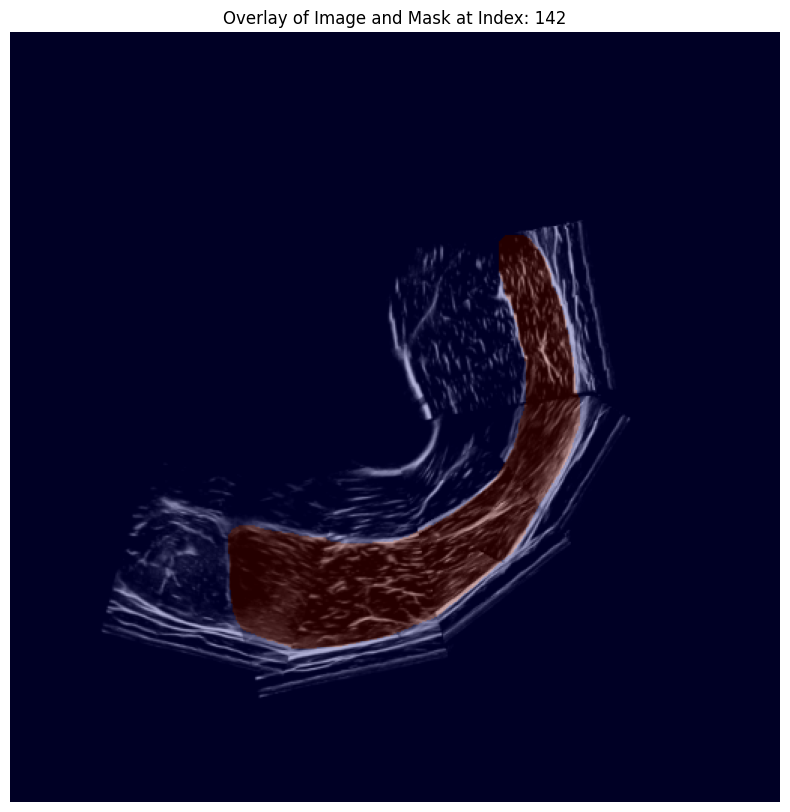

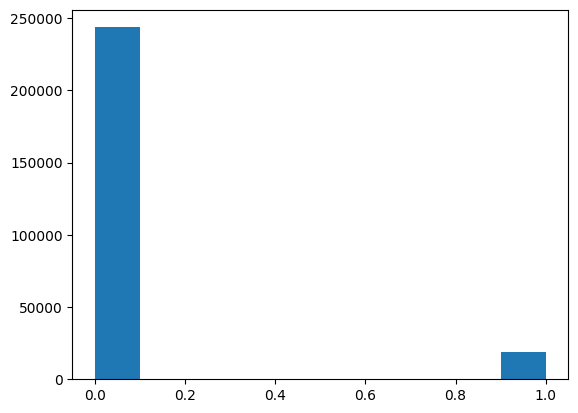

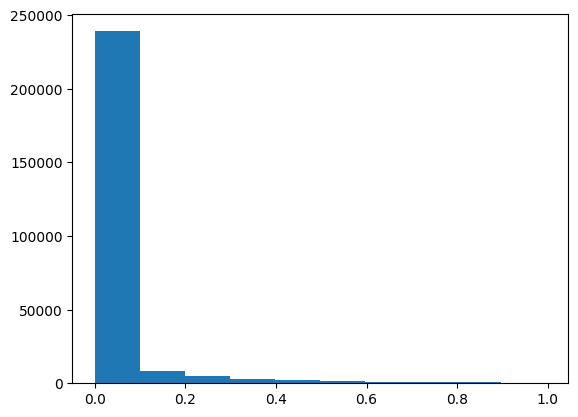

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to plot a random image with its corresponding mask overlay
def plot_random_image_with_mask_overlay(x_train, y_train):

    # Flatten the list of all images and masks for easy random selection
    all_images = [frame for video in x_train for frame in video]
    all_masks = [mask for video in y_train for mask in video if mask is not None]

    # Select a random index
    random_index = random.randint(0, min(len(all_images), len(all_masks)) - 1)
    
    # Retrieve the corresponding image and mask
    random_image = all_images[random_index][1] # Image data
    random_mask = all_masks[random_index][..., 0][0]    # Mask data

    # Plot the image with its mask overlay
    plt.figure(figsize=(10, 10))
    plt.title(f"Overlay of Image and Mask at Index: {random_index}")
    
    # Display the image
    plt.imshow(random_image, cmap='gray')
    print(random_image.shape)
    
    # Overlay the mask with some transparency
    plt.imshow(random_mask, cmap='jet', alpha=0.3)  # Use 'jet' colormap to highlight the mask
    print(random_mask.shape)

    plt.axis('off')
    plt.show()
    plt.hist(random_mask.flatten())
    plt.show()

    plt.hist(random_image.flatten())
    plt.show()

# Call the function to plot an image with its mask overlay
plot_random_image_with_mask_overlay(x_train, y_train)





## Load validation data

In [13]:
# Define directories for masks and videos
mask_directory = 'C:/Users/camen/Documents/Carla_Master_Thesis/Data_IFSS_crop/val_mask/'
video_directory = 'C:/Users/camen/Documents/Carla_Master_Thesis/Data_IFSS_crop/val_video/'
sub_vol_size = 3
last_ind = sub_vol_size-1

# Loading the masks
mask_dataset = []
m_dataset = []
mask_number_all = []

for path in glob.glob(os.path.join(mask_directory, "video*")):

    frame_mask_dataset = []
    mask_number = []

    for mask_path in glob.glob(os.path.join(path, "*.tif")):

        filename = os.path.splitext(os.path.basename(mask_path))[0]
        number = filename.split('_')[-1]
        number = int(number)
        mask_number.append(number)

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (512,512))
        #mask = np.stack((mask, mask), axis=-1)
        mask = np.clip(np.where(mask>100, mask, 0), 0, 1)
        mask = np.expand_dims(mask, -1)
        mask = np.concatenate([mask, 1-mask], -1)
        mask = np.array(mask)
        #mask = mask/255.0
        frame_mask_dataset.append(mask) 

    frame_mask_dataset = np.array(frame_mask_dataset)
    mask_dataset.append(frame_mask_dataset)
    mask_number_all.append(mask_number)

    stacked_masks_set = []

    # Used for fully supervised learning, comment stacked_masks_set and m_dataset for weakly supervised learning
    # Stack the frames to create a set of 3 frames
    stacked_masks_set = np.array([np.stack([frame_mask_dataset[i], frame_mask_dataset[i+1], frame_mask_dataset[i+2]], axis=0)
                               for i in range(len(frame_mask_dataset) - last_ind)])

    # Append the stacked frames set directly to the image dataset
    m_dataset.append(stacked_masks_set)

# Loading and stacking the image frames
image_dataset = []
video_length = []

for path in glob.glob(os.path.join(video_directory, "video*")):

    frame_dataset = []

    for frame_path in glob.glob(os.path.join(path, "*.tif")):

        frame = cv2.imread(frame_path, 1)
        frame = cv2.resize(frame, (512,512))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.reshape((frame.shape[0], frame.shape[1], 1))
        frame = np.array(frame)/255.0
        frame_dataset.append(frame)

    frame_dataset = np.array(frame_dataset)
    single_video_length = len(frame_dataset)
    video_length.append(single_video_length)

    stacked_frames_set = []

     # Stack the frames to create a set of 3 frames
    stacked_frames_set = np.array([np.stack([frame_dataset[i], frame_dataset[i+1], frame_dataset[i+2]], axis=0)
                               for i in range(len(frame_dataset) - last_ind)])

    # Append the stacked frames set directly to the image dataset
    image_dataset.append(stacked_frames_set)

# Weakly supervised training
# Handling masks with missing data
#mask_dataset_complete = []
   
#for i in range(len(mask_number_all)):

#    target_length = video_length[i]
#    target_array = np.empty(target_length, dtype=object)
#    target_mask_set = mask_dataset[i]

#    for j in range(len(mask_number_all[i])):
#        target_array[mask_number_all[i][j]] = target_mask_set[j]

#    mask_dataset_complete.append(target_array)

#mask_dataset_complete = np.array(mask_dataset_complete, dtype=object)

# Fully supervised training
x_val = image_dataset
y_val = m_dataset
# Weakly supervised training
#x_val = np.array(image_dataset, dtype=object)
#y_val = mask_dataset_complete


## Plot Masks during training

In [14]:
import matplotlib.pyplot as plt
import os

def plot_batch_with_masks(x_batch, y_true_batch, output_masks, save_dir='batch_plots', epoch=None):
    """
    Plots the 2nd frame (index 1) from the 1st batch with its ground truth and predicted mask.
    """

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # ✅ Select 2nd image (index 1) from first batch
    batches = len(x_batch[-1])
    print(f"Number of batches: {batches}")
    x_image = x_batch[-1]          # Shape: (time, H, W, C)
    y_true = y_true_batch[-1]
    y_pred = output_masks[0]

    # ✅ Select the 2nd frame (index 1) and squeeze
    x_image_selected = x_image[batches-1, 1, ..., 0]
    x_image_selected = np.squeeze(x_image_selected)        # Shape: (H, W)
    y_true_selected = y_true[batches-1, 1, ..., 0]          # Shape: (H, W)
    y_true_selected = np.squeeze(y_true_selected)        # Shape: (H, W)
    y_pred_selected = y_pred[1, ..., 0]          # Shape: (H, W)
    

    # ✅ Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(x_image_selected, cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(y_true_selected, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(y_pred_selected, cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    # ✅ Save
    title = f"Epoch {epoch+1}" if epoch is not None else "Prediction"
    fig.suptitle(title)
    filename = f"epoch_{epoch+1}_frame_2.png" if epoch is not None else "frame_2.png"
    plt.savefig(os.path.join(save_dir, filename))
    plt.close()


## Training loop

In [36]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [15]:
import datetime

# TensorBoard log directory
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = tf.summary.create_file_writer(log_dir)


In [16]:
# Variable definitions
#loss_object = tf.keras.losses.binary_crossentropy

optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.Accuracy()
val_acc_metric = tf.keras.metrics.Accuracy()
train_iou_metric = tf.keras.metrics.MeanIoU(num_classes=2, axis=(1, 2, 3, 4))
val_iou_metric = tf.keras.metrics.MeanIoU(num_classes=2, axis=(1, 2, 3, 4))

epochs = 200

# Define ModelCheckpoint class
class ModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=0, save_best_only=False, mode='min'):
        super(ModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best = np.Inf if mode == 'min' else -np.Inf
        self.mode = mode

        if mode not in ['auto', 'min', 'max']:
            print(f"ModelCheckpoint mode {mode} is unknown, fallback to auto mode.")
            self.mode = 'auto'

        if self.mode == 'min':
            self.monitor_op = np.less
        elif self.mode == 'max':
            self.monitor_op = np.greater
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
            else:
                self.monitor_op = np.less

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            print(f"Warning: Monitor value {self.monitor} is not available in logs. Skipping checkpoint saving.")
            return
        
        filepath = self.filepath.format(epoch=epoch)

        if self.save_best_only:
            if self.monitor_op(current, self.best):
                if self.verbose > 0:
                    print(f"\nEpoch {epoch}: {self.monitor} improved from {self.best:.5f} to {current:.5f}, saving model to {filepath}")
                self.best = current
                self.model.save(filepath)
            else:
                if self.verbose > 0:
                    print(f"\nEpoch {epoch}: {self.monitor} did not improve from {self.best:.5f}")
        else:
            if self.verbose > 0:
                print(f"\nEpoch {epoch}: saving model to {filepath}")
            self.model.save(filepath)

# Define CSVLogger class
class CSVLogger(tf.keras.callbacks.Callback):
    def __init__(self, filename, separator=',', append=False):
        super(CSVLogger, self).__init__()
        self.filename = filename
        self.sep = separator
        self.append = append
        self.keys = None
        self.append_header = not append or not os.path.exists(filename)
        self.file_flags = 'a' if append else 'w'
        
    def on_train_begin(self, logs=None):
        self.csv_file = open(self.filename, self.file_flags, newline='')
        self.writer = csv.writer(self.csv_file, delimiter=self.sep)
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if self.keys is None:
            self.keys = sorted(logs.keys())
            if self.append_header:
                self.writer.writerow(['epoch'] + self.keys)
                
        row = [epoch] + [logs[k] for k in self.keys]
        self.writer.writerow(row)
        self.csv_file.flush()
        
    def on_train_end(self, logs=None):
        self.csv_file.close()

# Define EarlyStoppingCallback class
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def __init__(self, min_delta=0, patience=0):
        super().__init__()
        self.min_delta = min_delta
        self.patience = patience
        self.best = float('inf')
        self.wait = 0
        self.stopped_epoch = 0
        

    def on_epoch_end(self, epoch, logs):
        current = logs.get('val_loss')
        if current is None:
            return
        
        # Update the best validation loss
        if current < self.best - self.min_delta:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                if hasattr(self.model, 'stop_training'):
                    self.model.stop_training = True
                print(f"Epoch {epoch}: early stopping")
                return
    
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Training stopped early at epoch {self.stopped_epoch}")

# Define ReduceLROnPlateauCallback class
class ReduceLROnPlateauCallback(tf.keras.callbacks.Callback):
    def __init__(self, factor=0.1, min_lr=0.0000001, patience=4, threshold=0.0001):
        super().__init__()
        self.factor = factor
        self.min_lr = min_lr
        self.patience = patience
        self.threshold = threshold
        self.wait = 0
        self.best = float('inf')
    
    def on_epoch_end(self, epoch, logs):
        current = logs.get('val_loss')
        if current is None:
            return 
    
        current_lr = optimizer.learning_rate.numpy()

        # initialize or update the best validation loss
        if current < self.best - self.threshold:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                # reduce the learning rate
                new_lr = max(current_lr * self.factor, self.min_lr)
                optimizer.learning_rate.assign(new_lr)
                print(f"Epoch {epoch}: reducing learning rate to {new_lr:.6f}")
                self.wait = 0

# Define functions to validate data
@tf.function
def val_step(x_val, y_val):
    print(x_val.shape)
    output_masks = model(x_val, training=False)
    output_masks = tf.clip_by_value(output_masks, 0, 1)
    val_loss = focal_tversky(y_val, output_masks)

    dice_sim_coeff = dsc(y_val, output_masks)

    val_acc_metric.update_state(y_val, output_masks)
    val_iou_metric.update_state(y_val, output_masks)

    return val_loss, dice_sim_coeff, output_masks

def val_model(x_val, y_val):
    total_val_loss = []
    total_dice_sim_coeff = []

    for batch_idx in range(len(x_val)):
        x_batch = x_val[batch_idx]
        y_batch = y_val[batch_idx]

        for step in range(len(x_batch)):
            x_images = x_batch[step]
            x_images = x_images.reshape((1, x_images.shape[0], x_images.shape[1], x_images.shape[2], x_images.shape[3]))

            y_masks = y_batch[step]
            y_masks = y_masks.reshape((1, y_masks.shape[0], y_masks.shape[1], y_masks.shape[2], y_masks.shape[3]))
            
            val_loss, dice_sim_coeff, output_masks = val_step(x_images, y_masks)
            output_masks = tf.clip_by_value(output_masks, 0, 1)

            total_val_loss.append(val_loss)
            total_dice_sim_coeff.append(dice_sim_coeff)

    val_acc = val_acc_metric.result()
    val_iou = val_iou_metric.result()
    print(f"Accuracy over Validation Set: {val_acc} | IoU over Validation Set: {val_iou} | Dice Similarity Coefficient: {np.mean(total_dice_sim_coeff)}")
    val_acc_metric.reset_state()
    val_iou_metric.reset_state()

    return np.mean(total_val_loss), np.mean(total_dice_sim_coeff), val_iou, output_masks

# ✅ Updated Training Step (Only Uses `x_target` Now)
@tf.function
def train_step(x_train_batch, y_train_batch):
    with tf.GradientTape() as tape:
        output_masks = model(x_train_batch, training=True)
        output_masks = tf.clip_by_value(output_masks, 0, 1)  # Clip the output values
        loss = focal_tversky(y_train_batch, output_masks)
        dice_sim_coeff = dsc(y_train_batch, output_masks)

    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    train_acc_metric.update_state(y_train_batch, output_masks)
    train_iou_metric.update_state(y_train_batch, output_masks)

    return loss, output_masks, dice_sim_coeff

# ✅ Updated Training Loop (Using Stacked Frames)
def train_model(x_train, y_train, x_val, y_val, epochs):
    early_stopping = EarlyStoppingCallback(patience=10)
    reduce_lr = ReduceLROnPlateauCallback(factor=0.1, min_lr=0.0000001, patience=5)

    checkpoint_callback = ModelCheckpoint(filepath='IFSS_checkpoint_epoch{epoch:02d}.weights.h5', monitor='val_loss', save_best_only=True, verbose=1)
    checkpoint_callback.set_model(model)

    csv_logger = CSVLogger(filename='training_log.csv', separator=',', append=False)
    csv_logger.on_train_begin()

    total_batches = sum(len(batch) for batch in x_train)  # Total number of batches across steps

    for epoch in range(epochs):
        print(f"Start of training epoch: {epoch}")

        total_loss = []
        total_dice = []

        # Create a progress bar for the current epoch with the total number of batches
        with tqdm(total=total_batches, desc=f"Epoch {epoch+1}/{epochs} ({total_batches} batches)", unit="batch") as pbar:
            for batch_idx in range(len(x_train)):
                x_batch = x_train[batch_idx]
                y_batch = y_train[batch_idx]

                for step in range(len(x_batch)):
                    x_images = x_batch[step]
                    x_images = x_images.reshape((1, x_images.shape[0], x_images.shape[1], x_images.shape[2], x_images.shape[3]))
                    y_masks = y_batch[step]
                    y_masks = y_masks.reshape((1, y_masks.shape[0], y_masks.shape[1], y_masks.shape[2], y_masks.shape[3]))

                    loss, output_masks, train_dice = train_step(x_images, y_masks)
                    output_masks = tf.clip_by_value(output_masks, 0, 1)
                    total_loss.append(loss)
                    total_dice.append(train_dice)

                    pbar.update(1)

        # Calculate metrics for the current epoch
        train_acc = train_acc_metric.result()
        train_iou = train_iou_metric.result()
        print(f"Accuracy over epoch {epoch}: {train_acc} | IoU over epoch {epoch}: {train_iou} | Dice Similarity Coefficient: {np.mean(total_dice)}")
        train_acc_metric.reset_state()
        train_iou_metric.reset_state()

        print(f'Epoch {epoch}, Loss: {np.mean(total_loss)}')

        # Validate
        val_loss_epoch, dice_sim_coeff_epoch, val_iou_epoch, output_masks_val = val_model(x_val, y_val)

        logs = {'val_loss': np.array(val_loss_epoch), 
                'accuracy': train_acc.numpy(), 
                'iou': train_iou.numpy(), 
                'tversky_loss': np.mean(total_loss),
                'train_dice_similarity_coefficient': np.mean(train_dice),
                'val_dice_similarity_coefficient': np.array(dice_sim_coeff_epoch),
                }
        
         # tensoroard callbacks
        with writer.as_default():
            tf.summary.scalar('Loss/Train', np.mean(total_loss), step=epoch)
            tf.summary.scalar('Loss/Validation', val_loss_epoch, step=epoch)
            tf.summary.scalar('DiceCoeff/Train', np.mean(total_dice), step=epoch)
            tf.summary.scalar('IoU/Train', train_iou, step=epoch)
            tf.summary.scalar('IoU/Validation', val_iou_epoch, step=epoch)
            tf.summary.scalar('DiceCoeff/Validation', dice_sim_coeff_epoch, step=epoch)

        # Check predictions
        plot_batch_with_masks(x_val, y_val, output_masks_val, save_dir='batch_plots', epoch=epoch)

        # Callbacks
        early_stopping.on_epoch_end(epoch, logs=logs)
        reduce_lr.on_epoch_end(epoch, logs=logs)
        checkpoint_callback.on_epoch_end(epoch, logs=logs)
        csv_logger.on_epoch_end(epoch, logs=logs)

    csv_logger.on_train_end()

train_model(x_train, y_train, x_val, y_val, epochs=epochs)


Start of training epoch: 0


Epoch 1/200 (310 batches):   0%|          | 0/310 [00:00<?, ?batch/s]E0000 00:00:1742912421.245231    8934 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/functional_1_1/conv_lstm2d_3_1/while/functional_1_1/conv_lstm2d_3_1/while_grad/body/_547/input/_1129' -> 'gradient_tape/functional_1_1/conv_lstm2d_3_1/while/functional_1_1/conv_lstm2d_3_1/while_grad/body/_547/gradient_tape/functional_1_1/conv_lstm2d_3_1/while/gradients/AddN', 'Func/gradient_tape/functional_1_1/conv_lstm2d_2_1/while/functional_1_1/conv_lstm2d_2_1/while_grad/body/_357/input/_1013' -> 'gradient_tape/functional_1_1/conv_lstm2d_2_1/while/functional_1_1/conv_lstm2d_2_1/while_grad/body/_357/gradient_tape/functional_1_1/conv_lstm2d_2_1/while/gradients/AddN', 'functional_1_1/conv_lstm2d_3_1/while/body/_179/functional_1_1/conv_lstm2d_3_1/while/conv_lstm_cell_1/mul_4' -> 'functional_1_1/conv_lstm2d_3_1/while/body/_179/func

InvalidArgumentError: {{function_node __wrapped__Sum_device_/job:localhost/replica:0/task:0/device:GPU:0}} Invalid reduction dimension (1 for input with 1 dimension(s) [Op:Sum]

Load testing data

In [ ]:
mask_directory = 'C:/Users/admin/Documents/DL_Track/IFSS_Net/Data/Data/test_mask/'
video_directory = 'C:/Users/admin/Documents/DL_Track/IFSS_Net/Data/Data/test_video/'

sub_vol_size = 3
last_ind = sub_vol_size-1

mask_dataset = []
mask_number_all = []

for path in glob.glob(os.path.join(mask_directory, "video*")):

    frame_mask_dataset = []
    mask_number = []

    for mask_path in glob.glob(os.path.join(path, "*.tif")):

        filename = os.path.splitext(os.path.basename(mask_path))[0]
        number = filename.split('_')[-1]
        number = int(number)
        mask_number.append(number)

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (512,512))
        #mask = np.stack((mask, mask), axis=-1)
        mask = np.clip(np.where(mask>100, mask, 0), 0, 1)
        mask = np.expand_dims(mask, -1)
        mask = np.concatenate([mask, 1-mask], -1)
        mask = np.array(mask)
        #mask = mask/255.0
        frame_mask_dataset.append(mask) 

    frame_mask_dataset = np.array(frame_mask_dataset)
    mask_dataset.append(frame_mask_dataset)
    mask_number_all.append(mask_number)

image_dataset = []
video_length = []

for path in glob.glob(os.path.join(video_directory, "video*")):

    frame_dataset = []

    for frame_path in glob.glob(os.path.join(path, "*.tif")):

        frame = cv2.imread(frame_path, 1)
        frame = cv2.resize(frame, (512,512))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.reshape((frame.shape[0], frame.shape[1], 1))
        frame = np.array(frame)/255.0
        frame_dataset.append(frame)

    frame_dataset = np.array(frame_dataset)
    single_video_length = len(frame_dataset)
    video_length.append(single_video_length)

    # Stack the frames to create a set of 3 frames
    stacked_frames_set = np.array([np.stack([frame_dataset[i], frame_dataset[i+1], frame_dataset[i+2]], axis=0)
                               for i in range(len(frame_dataset) - last_ind)])

    # Append the stacked frames set directly to the image dataset
    image_dataset.append(stacked_frames_set)


#mask_dataset_complete = []
    
#for i in range(len(mask_number_all)):

    #target_length = video_length[i]
    #target_array = np.empty(target_length, dtype=object)
    #target_mask_set = mask_dataset[i]

    #for j in range(len(mask_number_all[i])):
        #target_array[mask_number_all[i][j]] = target_mask_set[j]

    #mask_dataset_complete.append(target_array)

#mask_dataset_complete = np.array(mask_dataset_complete, dtype=object)

x_test = image_dataset
#y_test = mask_dataset_complete
y_test = mask_dataset

Testing loop

In [ ]:
# functions to test accuracy of IFSS-Model over test data
# input video test data (22, 3, 512, 512, 1)-> 22 arrays each containing 3 consecutive video frames
# input mask test data (3, 512, 512, 1)-> 3 labelled masks of the first 3 video frames

from tensorflow.keras.models import load_model


model = load_model('IFSS_checkpoint_epoch04.weights.h5', custom_objects={'focal_tversky': focal_tversky, 'IoU': IoU})

test_acc_metric = tf.keras.metrics.Accuracy()
test_iou_metric = tf.keras.metrics.MeanIoU(num_classes=2)

# define functions to test data
@tf.function
def test_step(x_test, y_test):
    output_masks = model([x_test, y_test], training = False)
    test_acc_metric.update_state(y_test[:, 1:3, :, :, :1], output_masks[:, :2, :, :, :1])
    test_iou_metric.update_state(y_test[:, 1:3, :, :, :1], output_masks[:, :2, :, :, :1])
    
    return output_masks

def test_model(x_test, y_test):

    for batch_idx in range(len(x_test)):

        x_batch = x_test[batch_idx]
        y_batch = y_test[batch_idx] # in testing only a few input masks to beginn with
        
        for step in range(len(x_batch)):
                
            x_images = x_batch[step]
            x_images = x_images.reshape((1, x_images.shape[0], x_images.shape[1], x_images.shape[2], x_images.shape[3]))

            if step == 0 or step == 1:
                y_masks = np.stack(y_batch[0:3], axis=0)
            if step == 2:
                y_masks = y_masks.copy()
                y_masks[0] = y_batch[1]
                y_masks[1] = y_batch[2]
            if step == 3:
                y_masks = y_masks.copy()
                y_masks[0] = y_batch[2]
            
            y_masks = y_masks.reshape((1, y_masks.shape[0], y_masks.shape[1], y_masks.shape[2], y_masks.shape[3]))
            
            output_masks = test_step(x_images, y_masks)
            y_masks = tf.clip_by_value(output_masks, 0, 1) # Clip values between 0 and 1
            
            y_masks = output_masks.numpy()
            y_masks = y_masks.reshape((y_masks.shape[1], y_masks.shape[2], y_masks.shape[3], y_masks.shape[4]))
    
    test_acc = test_acc_metric.result()
    test_iou = test_iou_metric.result()
    print(f"Accuracy over Test Set: {test_acc} | IoU over Test Set: {test_iou}")
    test_acc_metric.reset_state()

test_model(x_test, y_test)  

## Load data for prediction

In [18]:
mask_directory = '../data/test/mask/MZP1/'
video_directory = '../data/test/volume/MZP1/'

#model = load_model('IFSS_checkpoint_epoch09.weights.h5', custom_objects={'focal_tversky': focal_tversky, 'IoU': IoU})

#mask_directory = 'C:/Users/admin/Documents/DL_Track/IFSS_Net/Data/Data/IFSSconv/val_mask/video_1/'
#video_directory = 'C:/Users/admin/Documents/DL_Track/IFSS_Net/Data/Data/IFSSconv/val_video/video_1/'
# Profiling start
#start_time = time.time()

# Loading masks
predict_mask = []
mask_number = []

mask_paths = glob.glob(os.path.join(mask_directory, "*.tif"))
print(f"Number of mask files: {len(mask_paths)}")

for mask_path in mask_paths:
    filename = os.path.splitext(os.path.basename(mask_path))[0]
    number = int(filename.split('_')[-1])
    mask_number.append(number)

    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, (512, 512))  # Resizing to 512x512
    #mask = np.stack((mask, mask), axis=-1)  # Duplicate the mask for some reason
    mask = np.clip(np.where(mask>100, mask, 0), 0, 1)
    mask = np.expand_dims(mask, -1)
    mask = np.concatenate([mask, 1-mask], -1)
    #mask = mask / 255.0  # Normalize to [0,1]
    predict_mask.append(mask)

predict_mask = np.array(predict_mask)
#print(f"Time for loading and processing masks: {time.time() - start_time:.2f} seconds")

# Loading frames
#start_time = time.time()

frame_set = []
frame_paths = glob.glob(os.path.join(video_directory, "*.tif"))
print(f"Number of video frames: {len(frame_paths)}")

for frame_path in frame_paths:
    frame = cv2.imread(frame_path, 1)
    frame = cv2.resize(frame, (512, 512))  # Resize to 512x512
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    frame = frame.reshape((frame.shape[0], frame.shape[1], 1))  # Reshape to (512,512,1)
    frame = frame / 255.0  # Normalize to [0,1]
    frame_set.append(frame)

frame_set = np.array(frame_set)
#print(f"Time for loading and processing frames: {time.time() - start_time:.2f} seconds")

# Stacking frames
#start_time = time.time()
stacked_frames = []

# Stack the frames to create a set of 3 frames
#stacked_frames_set = np.array([np.stack([frame_dataset[i], frame_dataset[i+1], frame_dataset[i+2]], axis=0)
#                            for i in range(len(frame_dataset) - last_ind)])
stacked_frames_set = np.array([np.stack([frame_set[i], frame_set[i+1], frame_set[i+2]], axis=0)
                            for i in range(len(frame_set) - last_ind)])

# Append the stacked frames set directly to the image dataset
stacked_frames.append(stacked_frames_set)

predict_video = np.array(stacked_frames_set)
#print(f"Time for stacking frames: {time.time() - start_time:.2f} seconds")

Number of mask files: 320
Number of video frames: 320


## Prediction loop

In [19]:
# functions to predict masks from a video
# input video shape (22, 3, 512, 512, 1)-> 22 arrays each containing 3 consecutive video frames, in total 24 frames
# input mask shape (3, 512, 512, 2)-> 3 labelled masks for the first 3 video frames
# step size = 1

import time


@tf.function
def predict_step(x_data, y_data):
    output_masks = model([x_data, y_data], training=False)
    return output_masks

def predict_model(x_data, y_data):
    predictions = []

    for step in range(len(x_data)): # range(0, len(x_data), 3)
        x_images = x_data[step]
        x_images = x_images.reshape((1, x_images.shape[0], x_images.shape[1], x_images.shape[2], x_images.shape[3]))

        if step == 0 or step == 1:
            y_masks = np.stack(y_data[0:3], axis=0)
        if step == 2:
            y_masks = y_masks.copy()
            y_masks[0] = y_data[1]
            y_masks[1] = y_data[2]
        if step == 3:
            y_masks = y_masks.copy()
            y_masks[0] = y_data[2]
        
        y_masks = y_masks.reshape((1, y_masks.shape[0], y_masks.shape[1], y_masks.shape[2], y_masks.shape[3]))
        
        output_masks = predict_step(x_images, y_masks)
        output_masks = tf.clip_by_value(output_masks, 0, 1)
        y_masks = output_masks.numpy()
        y_masks = y_masks.reshape((y_masks.shape[1], y_masks.shape[2], y_masks.shape[3], y_masks.shape[4]))

        selected_output = y_masks[1, :, :, :]
        predictions.append(selected_output)

    return predictions

start_time = time.time()

predictions = predict_model(predict_video, predict_mask)
np.save('valset_2_total_crop', predictions)
end_time = time.time()
total_time = end_time - start_time
print(total_time)

E0000 00:00:1742481423.565837   39765 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'functional_1/conv_lstm2d_1_1/while/body/_1/functional_1/conv_lstm2d_1_1/while/conv_lstm_cell_1/mul' -> 'functional_1/conv_lstm2d_1_1/while/body/_1/functional_1/conv_lstm2d_1_1/while/conv_lstm_cell_1/add_7', 'functional_1/conv_lstm2d_1_1/while/body/_1/functional_1/conv_lstm2d_1_1/while/conv_lstm_cell_1/Tanh_1' -> 'functional_1/conv_lstm2d_1_1/while/body/_1/functional_1/conv_lstm2d_1_1/while/conv_lstm_cell_1/mul_2', 'functional_1/conv_lstm2d_1_1/while/body/_1/functional_1/conv_lstm2d_1_1/while/conv_lstm_cell_1/convolution_7' -> 'functional_1/conv_lstm2d_1_1/while/body/_1/functional_1/conv_lstm2d_1_1/while/conv_lstm_cell_1/ArithmeticOptimizer/AddOpsRewrite_Leaf_1_add_8', 'functional_1/conv_lstm2d_2/while/body/_44/functional_1/conv_lstm2d_2/while/conv_lstm_cell_1/mul' -> 'functional_1/conv_lstm2d_2/while/body/_44/funct

37.957006216049194


## Plotting of predictions

(318, 512, 512, 2)


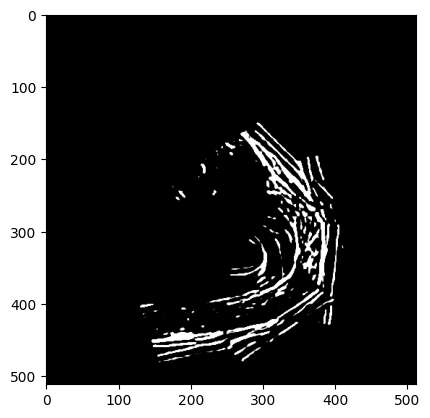

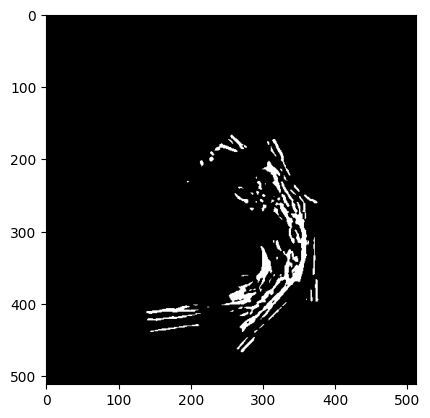

: 

In [ ]:
predictions = np.array(predictions)
threshold = 0.5
predictions_thresh = (predictions > threshold).astype(np.float32)
print(predictions_thresh.shape)


plt.imshow(predictions[100, :, :, 0], cmap='gray')
plt.show()
plt.imshow(predictions_thresh[5, :, :, 0], cmap='gray')
plt.show()

(79, 512, 512, 2)
1.0


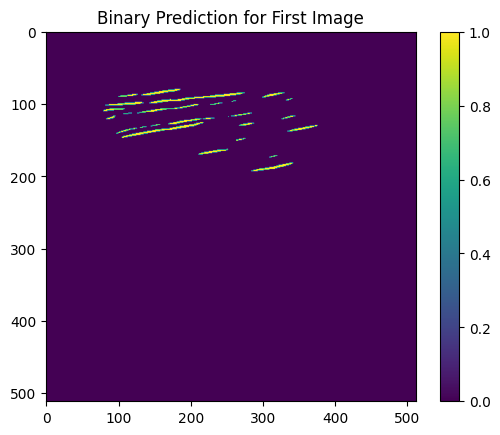

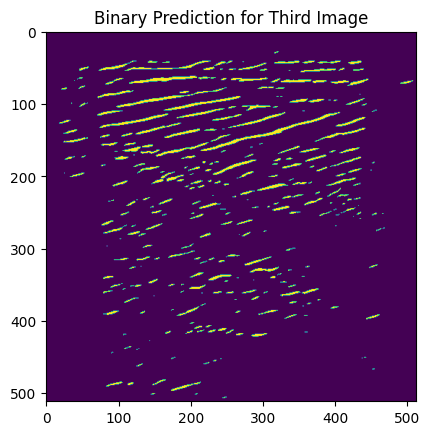

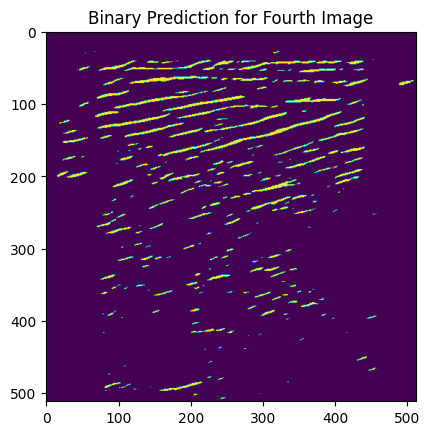

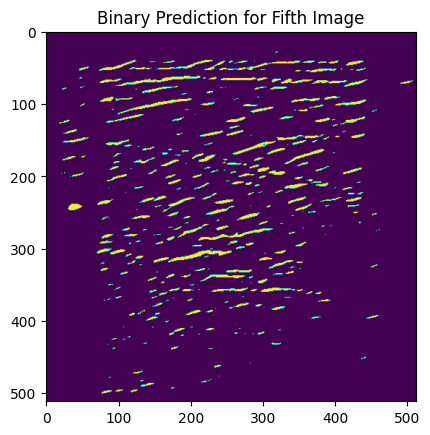

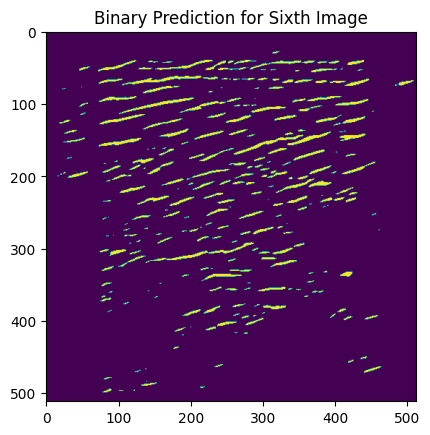

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the predictions are in the range [0, 1], not [0, 255]
predictions = np.array(predictions)

# Apply threshold for binary prediction (0.5 is typical for probabilities in range [0, 1])
threshold = 0.5
predictions_thresh = (predictions > threshold).astype(np.float32)

# Print the shape of the binary predictions
print(predictions_thresh.shape)
print(np.max(predictions[0, :, :, 0]))

# Visualize the first prediction (binary mask)
im = plt.imshow(predictions_thresh[0, :, :, 0], cmap='viridis')
plt.colorbar(im)
plt.title("Binary Prediction for First Image")
plt.show()

# Visualize the second prediction (binary mask)
plt.imshow(predictions_thresh[2, :, :, 0], cmap='viridis')
plt.title("Binary Prediction for Third Image")
plt.show()

plt.imshow(predictions_thresh[3, :, :, 0], cmap='viridis')
plt.title("Binary Prediction for Fourth Image")
plt.show()

plt.imshow(predictions_thresh[4, :, :, 0], cmap='viridis')
plt.title("Binary Prediction for Fifth Image")
plt.show()

plt.imshow(predictions_thresh[5, :, :, 0], cmap='viridis')
plt.title("Binary Prediction for Sixth Image")
plt.show()




In [ ]:
import nrrd 

def load_and_preprocess_volumes(volume_file, mask_file, num_classes, patch_size=None):
    x_data = []
    y_data = []
    
        # load vol and mask
    volume_data, _= nrrd.read(volume_file)
    mask_data, _ = nrrd.read(mask_file)
     
        # normalizing the vol
    volume_data = (volume_data - np.min(volume_data)) / (np.max(volume_data) - np.min(volume_data))
    
    volume_data = np.expand_dims(volume_data, axis=-1)  # adds the channel 
    volume_data = np.expand_dims(volume_data, axis=0)  # adds the batch 
    
    # One-hot encoding of mask
    mask_data_onehot = np.eye(num_classes)[mask_data] # one-hot encoding
    mask_data_onehot = np.expand_dims(mask_data_onehot, axis=0) # <dds batch

    x_data.append(volume_data)
    y_data.append(mask_data_onehot)

    return np.array(x_data), np.array(y_data)

# Esempio di utilizzo
volume_file = "C:/Users/diego/Bac Sport and Computer Science/Documents/BA-arbeit/RepoBA/VL_009_MZP2.nrrd"
mask_file = "C:/Users/diego/Bac Sport and Computer Science/Documents/BA-arbeit/RepoBA/Segmentation_VL_009_MZP2.seg.nrrd"
patch_size = (16, 128, 128)  # Dividi i volumi in patch di dimensioni (depth, height, width)

x_train, y_train = load_and_preprocess_volumes(volume_file, mask_file, num_classes=21, patch_size=patch_size)
#x_val, y_val = load_and_preprocess_volumes("path_to_val_volumes", "path_to_val_masks", num_classes=2, patch_size=patch_size)

print(f"Forma x_train: {x_train.shape}, y_train: {y_train.shape}")


MemoryError: Unable to allocate 24.6 GiB for an array with shape (730, 530, 407, 21) and data type float64

In [ ]:
# Percorsi ai file
volume_path = "C:/Users/diego/Bac Sport and Computer Science/Documents/BA-arbeit/RepoBA/VL_009_MZP2.nrrd"
mask_path = "C:/Users/diego/Bac Sport and Computer Science/Documents/BA-arbeit/RepoBA/Segmentation_VL_009_MZP2.seg.nrrd"

# Caricamento dei dati
volume_data, _ = nrrd.read(volume_path)  # Carica il volume
mask_data, _ = nrrd.read(mask_path)      # Carica la maschera

# Normalizza il volume tra 0 e 1
volume_data = (volume_data - np.min(volume_data)) / (np.max(volume_data) - np.min(volume_data))

# Aggiungi dimensioni batch e canale al volume
volume_data = np.expand_dims(volume_data, axis=-1)  # Aggiungi canale
volume_data = np.expand_dims(volume_data, axis=0)   # Aggiungi batch

# Converte la maschera in formato one-hot 
num_classes = 22
mask_data_onehot = np.eye(num_classes)[mask_data]  # One-hot encoding
mask_data_onehot = np.expand_dims(mask_data_onehot, axis=0)  # Aggiungi batch

# Stampa le forme finali
print("Forma del volume:", volume_data.shape)        # (1, depth, height, width, 1)
print("Forma della maschera:", mask_data_onehot.shape)  # (1, depth, height, width, num_classes)


Forma del volume: (1, 730, 530, 407, 1)
Forma della maschera: (1, 730, 530, 407, 22)
